### COSMOS

In [1]:
import torch
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
import utils.misc as misc
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from utils.data_loader import CosmosTestDataset

/uufs/chpc.utah.edu/common/home/u1367465/miniconda3/envs/dash/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /uufs/chpc.utah.edu/common/home/u1367465/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /uufs/chpc.utah.edu/common/home/u1367465/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /uufs/chpc.utah.edu/common/home/u1367465/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import matplotlib.pyplot as plt
import random

def denormalize_image(normalized_image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1) 
    std = torch.tensor(std).view(-1, 1, 1)   

    denormalized_image = normalized_image * std + mean

    denormalized_image = denormalized_image.clamp(0, 1)
    
    return denormalized_image

def visualize_results(preds, gts, dataset, k=5):
    indices = random.sample(range(len(preds)), k)
    
    for idx in indices:
        # Get data
        image, bboxes, _, _, label, bert_score, caption1, caption2 = dataset[idx]
        pred_label = preds[idx]
        gt_label = gts[idx]

        # Plot image
        image = denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        plt.imshow(image.permute(1, 2, 0))  # if image is a tensor with shape (C, H, W)
        plt.axis('off')
        plt.title(f"Prediction: {'Out-of-context' if pred_label else 'In-context'} | "
                  f"Ground Truth: {'Out-of-context' if gt_label else 'In-context'} | "
                  f"{'✓' if pred_label == gt_label else '✗'}")
        plt.show()

        # Print captions
        print(f"Caption 1: {caption1}")
        print(f"Caption 2: {caption2}")
        print(f"BERT Score: {bert_score:.4f}")
        print("-" * 60)
        
        

In [ ]:
from networks.cosmos import CosmosFullModel


class CosmosTest:
    def __init__(self, load_path, device):
        self.device = device
        self.model = CosmosFullModel(300, device)
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        
        transform_full = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ]) 
        
        self.test_dataset = CosmosTestDataset(json_file="data/cosmos_anns_acm/cosmos_anns_acm/acm_anns/public_test_acm.json", \
            img_dir="data", transform_full=transform_full)

        self.dataloader = DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=1
        )
        
        
    def collate_fn(self, batch):
        images, bboxes, caption_match, caption_diff, label, bert_score, caption1_orig, caption2_orig  = zip(*batch)
        return list(images), list(bboxes), list(caption_match), list(caption_diff), list(label), list(bert_score), list(caption1_orig), list(caption2_orig)

    def get_prediction(self, caption1_scores, caption2_scores, bboxes, bert_score):
        caption1_bboxes = misc.top_bbox_from_scores(bboxes, caption1_scores)
        caption2_bboxes = misc.top_bbox_from_scores(bboxes, caption2_scores)
        bbox_overlap = misc.is_bbox_overlap(caption1_bboxes, caption2_bboxes, 0.5)
        if bbox_overlap:
            if bert_score >= 0.5:
                context = 0
            else:
                context = 1
            return context
        else:
            return 0
        
    def run_test(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        all_scores = []
        with torch.no_grad():
            for image, bboxes, caption1, caption2, label, bert_score, _, _  in tqdm(self.dataloader, desc="Test Batch:"):
                object_embeddings, caption1_embeddings, caption2_embeddings = self.model(image, bboxes, caption1, caption2)
                caption1_scores = torch.einsum("bkd,bd->bk", object_embeddings, caption1_embeddings)
                caption2_scores = torch.einsum("bkd,bd->bk", object_embeddings, caption2_embeddings)
                bboxes = [bbox.tolist() for bbox in bboxes[0]]
                labels = label[0].item()
                score1_per_image = caption1_scores.max(dim=1).values   
                score2_per_image = caption2_scores.max(dim=1).values 
                all_scores.append(-min(score1_per_image.item(), score2_per_image.item()))
                preds = self.get_prediction(caption1_scores[0].tolist(), caption2_scores[0].tolist(), bboxes, bert_score[0].item())
                all_preds.append(preds)
                all_labels.append(labels)
                
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        ap = average_precision_score(all_labels, all_scores)       
        
        tqdm.write(f"Test Metrics: Accuracy = {accuracy}, F1 Score = {f1}, Average Precision = {ap}") 
        
        return all_preds, all_labels

In [12]:
ct = CosmosTest(load_path="checkpoints/cosmos/save/maskrcnn_use_acc.torch", device="cuda:0")
all_preds, all_labels = ct.run_test()

/tmp/ipykernel_3998402/389207504.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)
Test Batch::   2%|▎         | 25/1000 [00:02<00:44, 2

Test Batch:: 100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s]

Test Metrics: Accuracy = 0.768, F1 Score = 0.7827715355805244, Average Precision = 0.5643584365077564


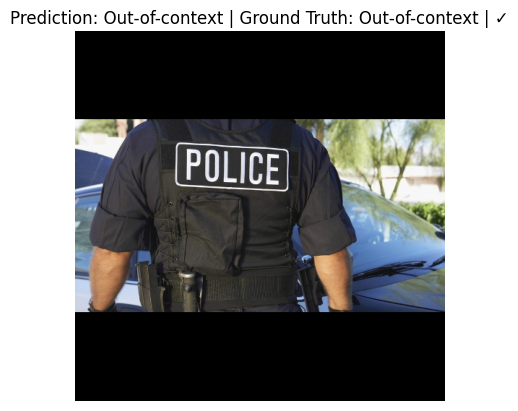

Caption 1: Law enforcement agencies in a Michigan county were on the lookout for a “vigilante” serial killer after three pedophiles were murdered in the span of one week.
Caption 2: Police departments in both Macomb County, Michigan, and Longview, Texas, responded to this hoax on Facebook to reassure their communities that no serial killers were on the loose in those localities
BERT Score: 0.3879
------------------------------------------------------------


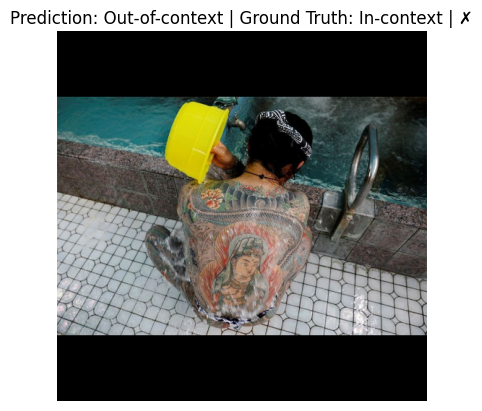

Caption 1: Construction worker Hiraku Sasaki, 48
Caption 2: A man with body tattoos pours water over his back
BERT Score: 0.1872
------------------------------------------------------------


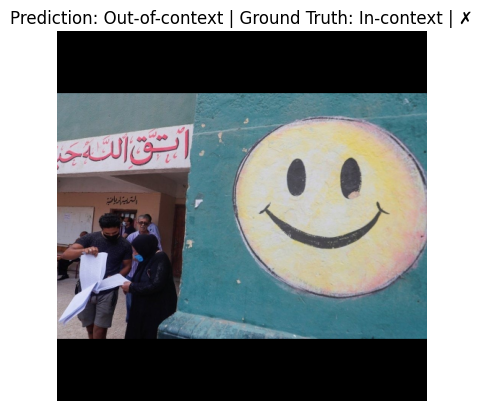

Caption 1: People stand at the entrance to a school used as a polling station.
Caption 2: One wall is daubed with a large, smiley face.
BERT Score: 0.0370
------------------------------------------------------------


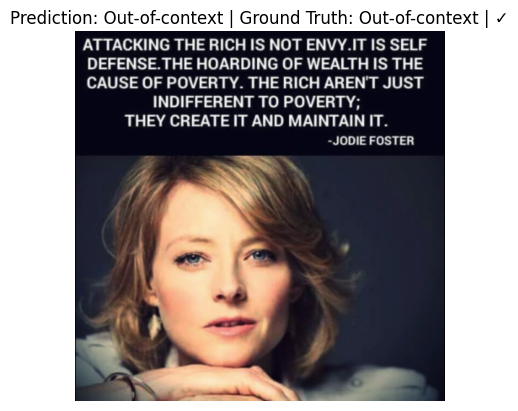

Caption 1: Actress Jodie Foster said that attacking the rich is not envy, it's self-defense.
Caption 2: This quote about wealth disparity in the United States did not originate with Jodie Foster
BERT Score: 0.2879
------------------------------------------------------------


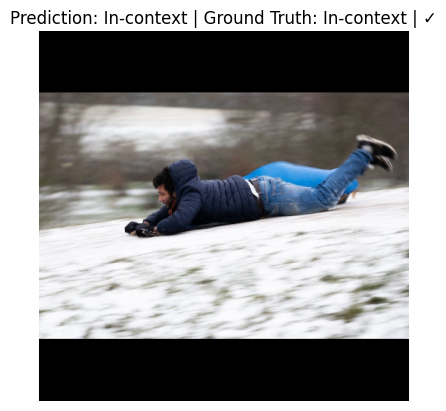

Caption 1: A man sleds down Primrose Hill, in north London
Caption 2: A man sleds down Primrose Hill in London, on 8 February 2021
BERT Score: 0.8112
------------------------------------------------------------


In [13]:
visualize_results(all_preds, all_labels, ct.test_dataset)

In [3]:
from networks.ooc_models import OOCBasic
from utils.data_loader import CosmosTestDataset
from transformers import AutoTokenizer
from collections import defaultdict
import numpy as np

class OOCBasicTest:
    def __init__(self, load_path, device):
        self.device = device
        self.model = OOCBasic(img_model="vit_base_patch16_224", txt_model="sentence-transformers/all-mpnet-base-v2",
                 embed_dim=768, proj_dim=256, num_heads=8)
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        
        transform_full = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ]) 
        
        self.tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
        
        self.test_dataset = CosmosTestDataset(json_file="data/cosmos_anns_acm/cosmos_anns_acm/acm_anns/public_test_acm.json", \
            img_dir="data", transform_full=transform_full, size=224)

        self.dataloader = DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=1
        )
        
        
    def collate_fn(self, batch):
        images, bboxes, caption1, caption2, label, bert_score, _, _ = zip(*batch)
        images = torch.stack(images, dim=0)
        
        caption1_tokens = self.tokenizer(
            caption1, return_tensors='pt', padding=True, truncation=True, max_length=32
        )
        caption2_tokens = self.tokenizer(
            caption2, return_tensors='pt', padding=True, truncation=True, max_length=32
        )

        return images, caption1_tokens, caption2_tokens, torch.stack(label, dim=0), torch.stack(bert_score, dim=0)

    def get_prediction(self, caption1_dist, caption2_dist, bert_score):
        if bert_score >= 0.5 and caption1_dist < 0.5 and caption2_dist < 0.5:
            return 0
        return 1
    
    def get_prediction_onsim(self, caption1_score, caption2_score, bert_score, c2c_sim):
        if bert_score > 0.5 and caption1_score > 0 and caption2_score > 0:
            return 0
        return 1
        
    def run_test(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        all_scores = []
        some_dict = defaultdict(list)
        with torch.no_grad():
            for image, caption1, caption2, label, bert_score in tqdm(self.dataloader, desc="Test Batch:"):
                image = image.to(self.device)
                caption1 = caption1.to(self.device)
                caption2 = caption2.to(self.device)
                object_embeddings, caption1_embeddings, caption2_embeddings = self.model(image, caption1, caption2)
                labels = label[0].item()
                caption1_sim = (object_embeddings * caption1_embeddings).sum(dim=1).cpu()
                caption2_sim = (object_embeddings * caption2_embeddings).sum(dim=1).cpu()
                c2c_sim = (caption1_embeddings * caption2_embeddings).sum(dim=1).cpu()
                preds = self.get_prediction_onsim(caption1_sim[0].item(), caption2_sim[0].item(), bert_score[0].item(), c2c_sim[0].item())
                all_scores.append(-min(caption1_sim[0].item(), caption2_sim[0].item()))
                all_preds.append(preds)
                all_labels.append(labels)
                 
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        ap = average_precision_score(all_labels, all_scores)       
        tqdm.write(f"Test Metrics: Accuracy = {accuracy}, F1 Score = {f1}, Average Precision = {ap}") 
        
        return all_preds, all_labels

In [25]:
ooc_basic_test = OOCBasicTest(load_path="checkpoints/ooc_basic/save/ooc_acc.torch", device="cuda:0")
all_preds, all_labels = ooc_basic_test.run_test()

/tmp/ipykernel_989624/4285786147.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


Test Batch:: 100%|██████████| 1000/1000 [00:29<00:00, 33.56it/s]

Test Metrics: Accuracy = 0.745, F1 Score = 0.7683923705722071, Average Precision = 0.5770378181718038


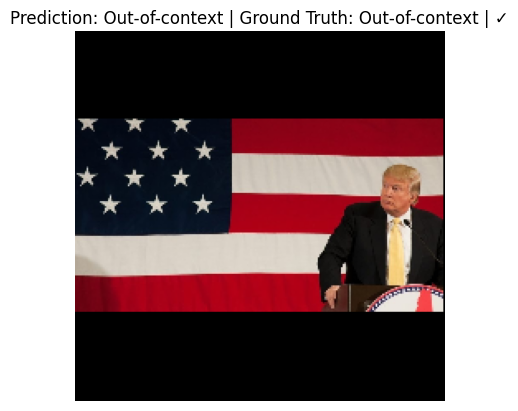

Caption 1: Paula White Selling Prayer Flags Blessed by Donald Trump.
Caption 2: A hoax article reported that televangelist Paula White was selling American flags that had been personally blessed by the United States President.
BERT Score: 0.6805
------------------------------------------------------------


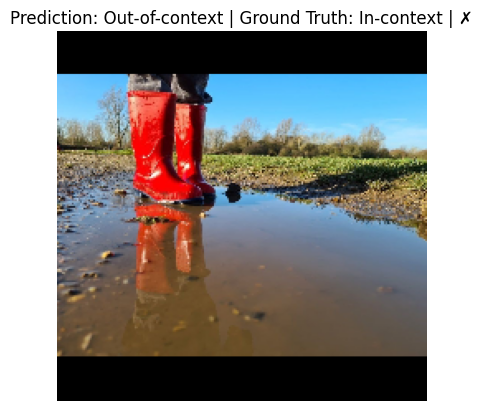

Caption 1: A child in red boots standing in a puddle
Caption 2: This photograph was taken by Louise Smart during a walk with her sons in Maldon, Essex
BERT Score: 0.2680
------------------------------------------------------------


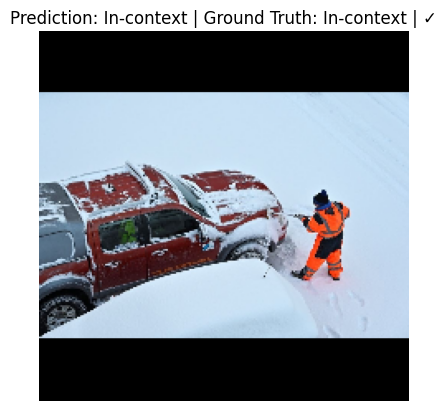

Caption 1: A man clears snow from his truck in Dalgety Bay, Fife. More heavy snow is expected in Edinburgh, Dundee, Perth, Stirling and surrounding areas of Scotland, where an amber weather warning for snow is in place until 21:00 GMT on Tuesday.
Caption 2: A city service worker tries to clear the snow from the truck to start the working day. Snow is expected to fall by the end of the week.
BERT Score: 0.6433
------------------------------------------------------------


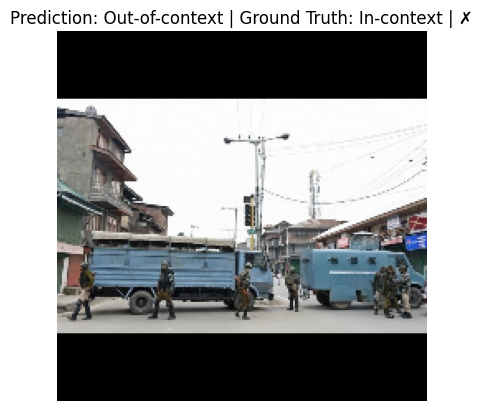

Caption 1: Indian paramilitary troops in Srinagar in Kashmir this month. Sixty eight percent of the army's equipment is so old that it is officially considered "vintage."
Caption 2: Kashmir braces for worst as shelling, gunbattles escalate
BERT Score: 0.2390
------------------------------------------------------------


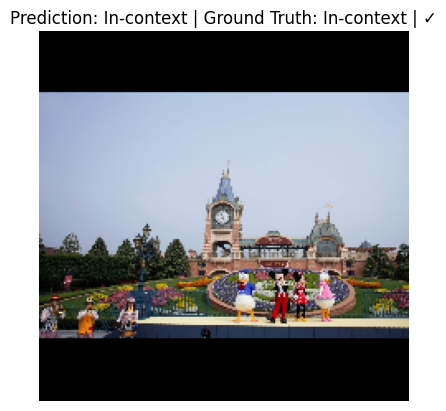

Caption 1: Disney's Shanghai park is the first of its six resorts around the world to reopen
Caption 2: Performers in a ceremony marking the reopening of Shanghai Disneyland
BERT Score: 0.6819
------------------------------------------------------------


In [17]:
visualize_results(all_preds, all_labels, ooc_basic_test.test_dataset)

In [ ]:
ooc_synth_test = OOCBasicTest(load_path="checkpoints/ooc_basic_synth/save/ooc_acc.torch", device="cuda:0")
all_preds, all_labels = ooc_synth_test.run_test()

/tmp/ipykernel_1928321/4285786147.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)
Test Batch:: 100%|██████████| 1000/1000 [00:41<00:0

Test Metrics: Accuracy = 0.737, F1 Score = 0.7686895338610378, Average Precision = 0.5902508657654706


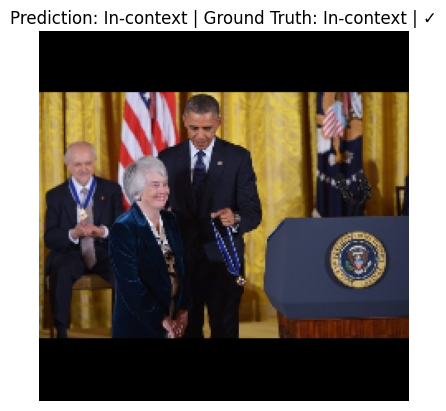

Caption 1: President Barack Obama presenting Patricia M. Wald with the Presidential Medal of Freedom, the country's highest civilian honor, in 2013.
Caption 2: President Barack Obama presents the Presidential Medal of Freedom to former judge Patricia Wald during a ceremony in the East Room of the White House on November 20, 2013 in Washington, DC. The Medal of Freedom is the country's highest civilian honor.
BERT Score: 0.8253
------------------------------------------------------------


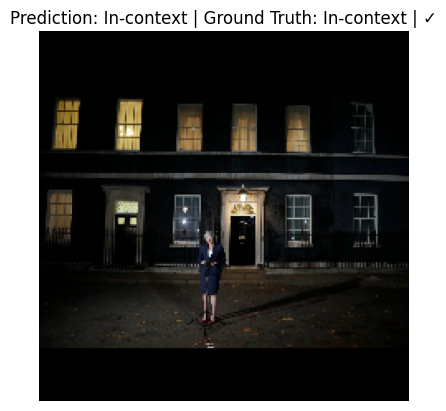

Caption 1: Britain's Prime Minister Theresa May announces that her Cabinet has agreed to a draft Brexit deal with the European Union after "impassioned" debate, outside 10 Downing Street in London. May told lawmakers Wednesday she is prepared to step down "earlier than I intended" in order to win passage of her Brexit divorce deal from the European Union.
Caption 2: Britain's Prime Minister Theresa May delivers a speech outside 10 Downing Street in London, Wednesday, Nov. 14, 2018. British Prime Minister Theresa May says Cabinet agrees draft Brexit deal with European Union after 'impassioned' debate.
BERT Score: 0.8555
------------------------------------------------------------


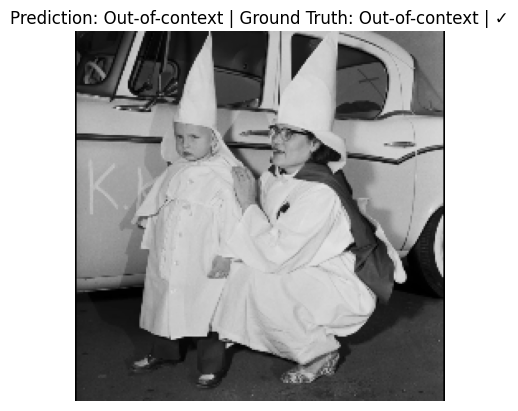

Caption 1: A photograph shows Georgia Gov. Brian Kemp and his mother dressed in KKK garb.
Caption 2: No evidence suggests this is actually a picture of the Georgia governor or his mother.
BERT Score: 0.4862
------------------------------------------------------------


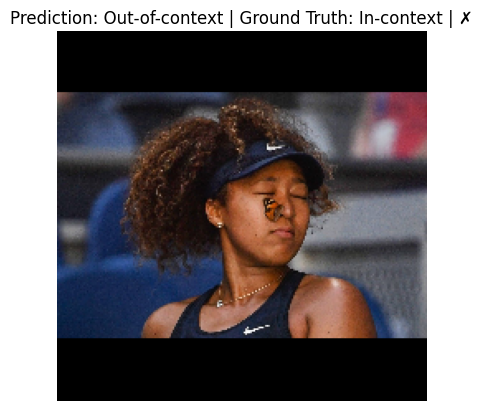

Caption 1: A butterfly interrupts play at the Australian Open
Caption 2: A butterfly on Naomi Osaka
BERT Score: 0.3589
------------------------------------------------------------


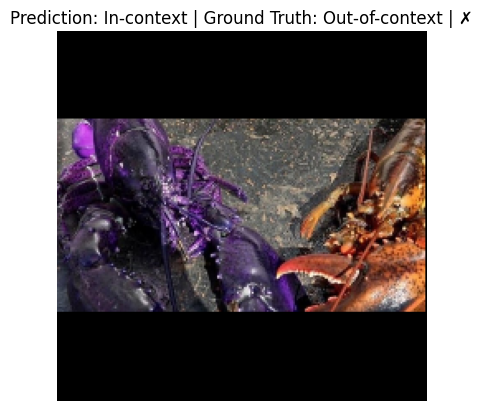

Caption 1: Maine lobsterman catches extremely rare purple lobster
Caption 2: These are not genuine photographs of a purple lobster.
BERT Score: 0.5300
------------------------------------------------------------


In [9]:
visualize_results(all_preds, all_labels, ooc_synth_test.test_dataset)